In [1]:
import getopt
import random
import sys
import time
from collections import deque
# make sure the root path is in system path
from pathlib import Path

from flatland.envs.malfunction_generators import malfunction_from_params
# base_dir = Path(__file__).resolve().parent.parent
# sys.path.append(str(base_dir))

import matplotlib.pyplot as plt
import numpy as np
import torch
from double_duelling_dqn import Agent
from observation_utils import normalize_observation

from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
from flatland.utils.rendertools import RenderTool
from flatland.envs.observations import TreeObsForRailEnv



cpu


In [2]:
def train(n_trials):

    #fix the randomness
    random.seed(1)
    np.random.seed(1)

    #parameters for the environment
    x_dim = 35
    y_dim = 35
    n_agents = 1
    
    # Use the malfunction generator to break agents from time to time
    stochastic_data = {'malfunction_rate': 8000,  # Rate of malfunction occurence of single agent
                       'min_duration': 15,  # Minimal duration of malfunction
                       'max_duration': 50  # Max duration of malfunction
                       }

    # Custom observation builder
    TreeObservation = TreeObsForRailEnv(max_depth=2)

    # Different agent types (trains) with different speeds.
    speed_ration_map = {1.: 0.,  # Fast passenger train
                        1. / 2.: 1.0,  # Fast freight train
                        1. / 3.: 0.0,  # Slow commuter train
                        1. / 4.: 0.0}  # Slow freight train


    env = RailEnv(width=x_dim,
                  height=y_dim,
                  rail_generator=sparse_rail_generator(max_num_cities=3,
                                                       # Number of cities in map (where train stations are)
                                                       seed=1,  # Random seed
                                                       grid_mode=False,
                                                       max_rails_between_cities=2,
                                                       max_rails_in_city=3),
                  schedule_generator=sparse_schedule_generator(),
                  number_of_agents=n_agents,
                  malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
                  # Malfunction data generator
                  obs_builder_object=TreeObservation)
    

    
    
    # After training we want to render the results so we also load a renderer
    env_renderer = RenderTool(env, gl="PILSVG", )
    obs , info = env.reset()
    #computing the size of the state space
    # Given the depth of the tree observation and the number of features per node we get the following state_size
    num_features_per_node = env.obs_builder.observation_dim
    tree_depth = 2
    nr_nodes = 0
    for i in range(tree_depth + 1):
        nr_nodes += np.power(4, i)
    state_size = num_features_per_node * nr_nodes

    # The action space of flatland is 5 discrete actions
    action_size = 5

    # And the max number of steps we want to take per episode
    max_steps = int(3 * (env.height + env.width))

    # Define training parameters
    eps = 1.
    eps_end = 0.005
    eps_decay = 0.998

    # And some variables to keep track of the progress
    action_dict = dict()
    final_action_dict = dict()
    scores_window = deque(maxlen=100)
    done_window = deque(maxlen=100)
    scores = []
    dones_list = []

    action_prob = [0] * action_size
    agent_obs = [None] * env.get_num_agents()
    agent_next_obs = [None] * env.get_num_agents()
    agent_obs_buffer = [None] * env.get_num_agents()
    agent_action_buffer = [2] * env.get_num_agents()
    cummulated_reward = np.zeros(env.get_num_agents())
    update_values = False
    # Now we load a Double dueling DQN agent
    agent = Agent(state_size, action_size)

    for trials in range(1, n_trials + 1):
        # Reset environment
        obs, info = env.reset(True, True)
        env_renderer.reset()
        
        for a in range(env.get_num_agents()):
            if obs[a]:
                agent_obs[a] = normalize_observation(obs[a], tree_depth, observation_radius=10)
                agent_obs_buffer[a] = agent_obs[a].copy()

        # Reset score and done
        score = 0
        env_done = 0

        # Run episode
        for step in range(max_steps):
            # Action
            for a in range(env.get_num_agents()):
                if info['action_required'][a]:
                    # If an action is require, we want to store the obs a that step as well as the action
                    update_values = True
                    action = agent.act(agent_obs[a], eps=eps)
                    action_prob[action] += 1
                else:
                    update_values = False
                    action = 0

                action_dict.update({a: action})
                
            # Environment step
            next_obs, all_rewards, done, info = env.step(action_dict)
            # Update replay buffer and train agent
            for a in range(env.get_num_agents()):
                # Only update the values when we are done or when an action was taken and thus relevant information is present
                if update_values or done[a]:
                    agent.step(agent_obs_buffer[a], agent_action_buffer[a], all_rewards[a],
                               agent_obs[a], done[a])
                    cummulated_reward[a] = 0.
                
                    agent_obs_buffer[a] = agent_obs[a].copy()
                    agent_action_buffer[a] = action_dict[a]
                
                if next_obs[a]:
                    agent_obs[a] = normalize_observation(next_obs[a], tree_depth, observation_radius=10)
                
                score += all_rewards[a] / env.get_num_agents()
                
            # Copy observation
            if done['__all__']:
                env_done = 1
                break
        
        # Epsilon decay
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        # Collection information about training
        tasks_finished = 0
        for _idx in range(env.get_num_agents()):
            if done[_idx] == 1:
                tasks_finished += 1

        done_window.append(tasks_finished / max(1, env.get_num_agents()))
        scores_window.append(score / max_steps)  # save most recent score
        scores.append(np.mean(scores_window))
        dones_list.append((np.mean(done_window)))

        print(
            '\rTraining {} Agents on ({},{}).\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
                env.get_num_agents(), x_dim, y_dim,
                trials,
                np.mean(scores_window),
                100 * np.mean(done_window),
                eps, action_prob / np.sum(action_prob)), end=" ")


        if trials % 100 == 0:
            print(
                '\rTraining {} Agents on ({},{}).\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
                    env.get_num_agents(), x_dim, y_dim,
                    trials,
                    np.mean(scores_window),
                    100 * np.mean(done_window),
                    eps, action_prob / np.sum(action_prob)))

            torch.save(agent.qnetwork_local.state_dict(),
                       './Nets/navigator_checkpoint' + str(trials) + '.pth')

            action_prob = [1] * action_size
            
    # Plot overall training progress at the end
    plt.plot(scores)
    plt.show()

    
            

Training 1 Agents on (35,35).	 Episode 100	 Average Score: -0.711	Dones: 48.00%	Epsilon: 0.82 	 Action Probabilities: 	 [0.18995343 0.19866933 0.2083167  0.1988024  0.20425815] 
Training 1 Agents on (35,35).	 Episode 200	 Average Score: -0.575	Dones: 67.00%	Epsilon: 0.67 	 Action Probabilities: 	 [0.18736687 0.18408979 0.20825823 0.19261019 0.22767491] 
Training 1 Agents on (35,35).	 Episode 300	 Average Score: -0.506	Dones: 75.00%	Epsilon: 0.55 	 Action Probabilities: 	 [0.15980719 0.21134594 0.15869485 0.19846125 0.27169077] 
Training 1 Agents on (35,35).	 Episode 400	 Average Score: -0.499	Dones: 83.00%	Epsilon: 0.45 	 Action Probabilities: 	 [0.16270996 0.2035282  0.15454631 0.2311157  0.24809984] 
Training 1 Agents on (35,35).	 Episode 500	 Average Score: -0.443	Dones: 84.00%	Epsilon: 0.37 	 Action Probabilities: 	 [0.15251373 0.208703   0.17384875 0.2299324  0.23500211] 
Training 1 Agents on (35,35).	 Episode 600	 Average Score: -0.414	Dones: 91.00%	Epsilon: 0.30 	 Action Probabi

Training 1 Agents on (35,35).	 Episode 4600	 Average Score: -0.244	Dones: 92.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.03534499 0.40797142 0.25982328 0.23463057 0.06222974] 
Training 1 Agents on (35,35).	 Episode 4700	 Average Score: -0.205	Dones: 96.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.00933541 0.43920871 0.24072016 0.21160258 0.09913314] 
Training 1 Agents on (35,35).	 Episode 4800	 Average Score: -0.240	Dones: 92.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.03635668 0.42345962 0.25143513 0.21794872 0.07079985] 
Training 1 Agents on (35,35).	 Episode 4900	 Average Score: -0.251	Dones: 91.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.00878317 0.43970723 0.25928637 0.25562672 0.03659652] 
Training 1 Agents on (35,35).	 Episode 5000	 Average Score: -0.222	Dones: 94.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.05350895 0.39164437 0.2132126  0.19386705 0.14776703] 
Training 1 Agents on (35,35).	 Episode 5100	 Average Score: -0.259	Dones: 88.00%	Epsilon: 0.01 	 Action P

Training 1 Agents on (35,35).	 Episode 8800	 Average Score: -0.193	Dones: 98.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.00987306 0.64809591 0.20427833 0.13563705 0.00211566] 
Training 1 Agents on (35,35).	 Episode 8900	 Average Score: -0.205	Dones: 97.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.00444741 0.65265733 0.23904825 0.10295753 0.00088948] 
Training 1 Agents on (35,35).	 Episode 9000	 Average Score: -0.256	Dones: 93.00%	Epsilon: 0.01 	 Action Probabilities: 	 [0.01687915 0.59597773 0.21009158 0.12138625 0.05566529] 
Training 1 Agents on (35,35).	 Episode 9032	 Average Score: -0.244	Dones: 95.00%	Epsilon: 0.01 	 Action Probabilities: 	 [3.43406593e-03 6.94368132e-01 1.72390110e-01 1.29120879e-01
Training 1 Agents on (35,35).	 Episode 9033	 Average Score: -0.254	Dones: 94.00%	Epsilon: 0.01 	 Action Probabilities: 	 [3.60144058e-03 6.93877551e-01 1.78871549e-01 1.23049220e-01
Training 1 Agents on (35,35).	 Episode 9034	 Average Score: -0.255	Dones: 94.00%	Epsilon: 0.01 	 Ac

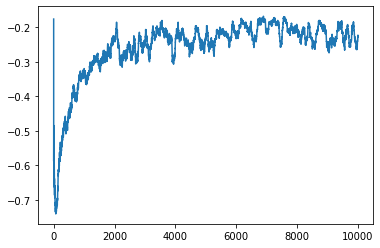

In [3]:
train(10000)